In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import pandas as pd
import re
import scanpy as sc
from scipy.sparse import csr_matrix

# Load data

In [166]:
# '../data_out/batches/crispr_guide_capture-stim_5.h5ad',
# '../data_out/batches/crispr_guide_capture-nostim_1.h5ad',

filename_1 = '../data_out/batches/gene_expression-stim_5.h5ad'
filename_2 = '../data_out/batches/gene_expression-nostim_1.h5ad'

In [167]:
adata_1 = sc.read(
    filename_1,
    cache=True,
    gex_only=False,
    # make_unique=True
)

adata_2 = sc.read(
    filename_2,
    cache=True,
    gex_only=False,
    # make_unique=True
)

In [168]:
adata = adata_1.concatenate(adata_2)

/tmp/ipykernel_109066/2196533220.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_1.concatenate(adata_2)


In [169]:
adata_1.shape[0] + adata_2.shape[0]

26812

In [170]:
adata

AnnData object with n_obs × n_vars = 26812 × 36601
    obs: 'condition', 'batch'
    var: 'gene_ids', 'feature_types', 'Gene Clean Name', 'CRISPr'

In [171]:
# Mas eficiente para entrenar
adata.X = csr_matrix(adata.X)

In [172]:
adata

AnnData object with n_obs × n_vars = 26812 × 36601
    obs: 'condition', 'batch'
    var: 'gene_ids', 'feature_types', 'Gene Clean Name', 'CRISPr'

In [173]:
adata.var.value_counts('CRISPr')

CRISPr
perturbed    36601
Name: count, dtype: int64

# Doublet removal
(two or more cells are mistakenly captured together and sequenced as if they were a single cell)

In [34]:
import scvi

In [35]:
# 13260 × 36601 -> 13260 × 17607
sc.pp.filter_genes(adata, min_cells=10)
adata

AnnData object with n_obs × n_vars = 13260 × 17607
    obs: 'condition', 'batch'
    var: 'gene_ids', 'feature_types', 'Gene Clean Name', 'CRISPr', 'n_cells'

In [36]:
# The top 2000 genes that describe the data
# 13260 × 17607 -> 13260 × 2000
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor='seurat_v3')
adata

AnnData object with n_obs × n_vars = 13260 × 2000
    obs: 'condition', 'batch'
    var: 'gene_ids', 'feature_types', 'Gene Clean Name', 'CRISPr', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [38]:
import torch
torch.set_float32_matmul_precision('medium')

In [39]:
# %% dl_num_workers
scvi.settings.dl_num_workers = 19
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.to_device('cuda')
vae.train()


/home/julian/miniconda3/envs/cellrep/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/julian/miniconda3/envs/cellrep/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [41]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


/home/julian/miniconda3/envs/cellrep/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.333. Signaling Trainer to stop.


In [42]:
df = solo.predict()
df['prediction'] = solo.predict(soft=False)
df['dif'] = df.doublet - df.singlet
df

/home/julian/miniconda3/envs/cellrep/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


/home/julian/miniconda3/envs/cellrep/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,doublet,singlet,prediction,dif
AAACCCAAGGGCGAAG-5,0.634632,0.365368,doublet,0.269264
AAACCCACACAAATAG-5,0.815543,0.184457,doublet,0.631087
AAACCCACAGGGATAC-5,0.592124,0.407876,doublet,0.184248
AAACCCAGTAAGACCG-5,0.267972,0.732028,singlet,-0.464055
AAACCCAGTCGTCGGT-5,0.743041,0.256959,doublet,0.486082
...,...,...,...,...
TTTGTTGTCAACCCGG-5,0.467000,0.533000,singlet,-0.066000
TTTGTTGTCCCTGGTT-5,0.976773,0.023227,doublet,0.953546
TTTGTTGTCCTACCGT-5,0.174151,0.825849,singlet,-0.651697
TTTGTTGTCGTTACCC-5,0.008613,0.991387,singlet,-0.982774


<Axes: >

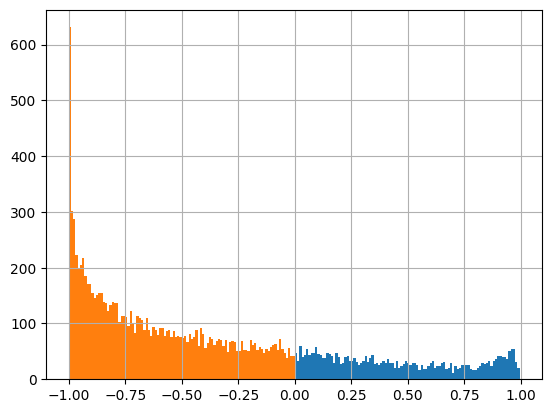

In [44]:
df[df['prediction']=='doublet']['dif'].hist(bins=100)
df[df['prediction']=='singlet']['dif'].hist(bins=100)

In [45]:
df.value_counts('prediction')

prediction
singlet    10030
doublet     3230
Name: count, dtype: int64

In [46]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 0.5)]
print(len(doublets)/len(df))
doublets

0.10437405731523379


,doublet,singlet,prediction,dif
AAACCCACACAAATAG-5,0.815543,0.184457,doublet,0.631087
AAACCCAGTGTTGACT-5,0.829668,0.170332,doublet,0.659336
AAACCCATCCGCGGAT-5,0.760751,0.239250,doublet,0.521501
AAACGCTGTAACAGTA-5,0.787806,0.212194,doublet,0.575612
AAAGGATAGGATGAGA-5,0.927292,0.072708,doublet,0.854584
...,...,...,...,...
TTTGGTTCAGATCCTA-5,0.985035,0.014965,doublet,0.970070
TTTGGTTCAGGTGTTT-5,0.764627,0.235373,doublet,0.529254
TTTGTTGCAAGGCCTC-5,0.774869,0.225131,doublet,0.549738
TTTGTTGGTGCATTTG-5,0.950162,0.049838,doublet,0.900324


In [51]:
adata = sc.read(
    filename,
    cache=True,
    gex_only=False,
    # make_unique=True
)

In [52]:
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata

AnnData object with n_obs × n_vars = 13260 × 36601
    obs: 'condition', 'batch', 'doublet'
    var: 'gene_ids', 'feature_types', 'Gene Clean Name', 'CRISPr'

In [53]:
adata = adata[~adata.obs['doublet']]
adata

View of AnnData object with n_obs × n_vars = 11876 × 36601
    obs: 'condition', 'batch', 'doublet'
    var: 'gene_ids', 'feature_types', 'Gene Clean Name', 'CRISPr'

# Preprocessing

In [174]:
# Mitocondrial, 13
adata.var['mt'] = adata.var.index.str.startswith('MT-')
adata.var.value_counts('mt')


mt
False    36588
True        13
Name: count, dtype: int64

In [175]:
# Ribosomal Genes
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes


,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [176]:
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
adata.var.value_counts('ribo')

ribo
False    36514
True        87
Name: count, dtype: int64

In [177]:
adata.var

,gene_ids,feature_types,Gene Clean Name,CRISPr,mt,ribo
MIR1302-2HG,ENSG00000243485,Gene Expression,MIR1302-2HG,perturbed,False,False
FAM138A,ENSG00000237613,Gene Expression,FAM138A,perturbed,False,False
OR4F5,ENSG00000186092,Gene Expression,OR4F5,perturbed,False,False
AL627309.1,ENSG00000238009,Gene Expression,AL627309.1,perturbed,False,False
AL627309.3,ENSG00000239945,Gene Expression,AL627309.3,perturbed,False,False
...,...,...,...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,AC141272.1,perturbed,False,False
AC023491.2,ENSG00000278633,Gene Expression,AC023491.2,perturbed,False,False
AC007325.1,ENSG00000276017,Gene Expression,AC007325.1,perturbed,False,False
AC007325.4,ENSG00000278817,Gene Expression,AC007325.4,perturbed,False,False


In [178]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

In [179]:
adata.var.sort_values('n_cells_by_counts')

,gene_ids,feature_types,Gene Clean Name,CRISPr,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,MIR1302-2HG,perturbed,False,False,0,0.000000,100.000000,0.0
AL590705.2,ENSG00000235494,Gene Expression,AL590705.2,perturbed,False,False,0,0.000000,100.000000,0.0
AL512590.3,ENSG00000286375,Gene Expression,AL512590.3,perturbed,False,False,0,0.000000,100.000000,0.0
AL162385.1,ENSG00000228174,Gene Expression,AL162385.1,perturbed,False,False,0,0.000000,100.000000,0.0
AL445531.1,ENSG00000260677,Gene Expression,AL445531.1,perturbed,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
MT-CO2,ENSG00000198712,Gene Expression,MT-CO2,perturbed,True,False,26784,100.513092,0.104431,2694957.0
MT-CO3,ENSG00000198938,Gene Expression,MT-CO3,perturbed,True,False,26784,121.269547,0.104431,3251479.0
MT-ND4,ENSG00000198886,Gene Expression,MT-ND4,perturbed,True,False,26784,60.793003,0.104431,1629982.0
MT-ATP6,ENSG00000198899,Gene Expression,MT-ATP6,perturbed,True,False,26787,87.026962,0.093242,2333367.0


In [180]:
sc.pp.filter_genes(adata, min_cells=3)
adata.var.sort_values('n_cells_by_counts')

,gene_ids,feature_types,Gene Clean Name,CRISPr,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
AC098969.2,ENSG00000288039,Gene Expression,AC098969.2,perturbed,False,False,3,0.000112,99.988811,3.0,3
AC068707.1,ENSG00000285712,Gene Expression,AC068707.1,perturbed,False,False,3,0.000112,99.988811,3.0,3
TP53AIP1,ENSG00000120471,Gene Expression,TP53AIP1,perturbed,False,False,3,0.000112,99.988811,3.0,3
ERC2-IT1,ENSG00000281708,Gene Expression,ERC2-IT1,perturbed,False,False,3,0.000112,99.988811,3.0,3
AP001122.1,ENSG00000245008,Gene Expression,AP001122.1,perturbed,False,False,3,0.000112,99.988811,3.0,3
...,...,...,...,...,...,...,...,...,...,...,...
MT-CO3,ENSG00000198938,Gene Expression,MT-CO3,perturbed,True,False,26784,121.269547,0.104431,3251479.0,26784
MT-CO2,ENSG00000198712,Gene Expression,MT-CO2,perturbed,True,False,26784,100.513092,0.104431,2694957.0,26784
MT-ND4,ENSG00000198886,Gene Expression,MT-ND4,perturbed,True,False,26784,60.793003,0.104431,1629982.0,26784
MT-ATP6,ENSG00000198899,Gene Expression,MT-ATP6,perturbed,True,False,26787,87.026962,0.093242,2333367.0,26787


In [181]:
adata.obs.sort_values('n_genes_by_counts')

,condition,batch,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TCCGTGTGTCCGGATC-5-0,Stim,0,72,598.0,538.0,89.966553,9.0,1.505017
GGGAGATTCTTAGCAG-1-1,Nostim,1,72,776.0,709.0,91.365982,8.0,1.030928
GGCGTCAAGTAGTGCG-1-1,Nostim,1,76,722.0,658.0,91.135735,12.0,1.662050
CACTGAAAGCGAGAAA-5-0,Stim,0,97,913.0,825.0,90.361443,14.0,1.533406
AGAAGTAGTGTTATCG-1-1,Nostim,1,97,946.0,839.0,88.689217,22.0,2.325581
...,...,...,...,...,...,...,...,...
CACGTTCAGATGCTTC-1-1,Nostim,1,6703,34494.0,2893.0,8.386966,4401.0,12.758740
TACTGCCCAGGAATCG-1-1,Nostim,1,6915,51794.0,4488.0,8.665096,8231.0,15.891802
AGATGAACAGCACCCA-1-1,Nostim,1,6948,44493.0,3789.0,8.515946,6525.0,14.665228
ACCTGTCCACAACGAG-1-1,Nostim,1,7259,43246.0,3187.0,7.369468,6181.0,14.292651


In [182]:
sc.pp.filter_cells(adata, min_genes=200)
adata.obs.sort_values('n_genes_by_counts')

,condition,batch,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
AGTGACTAGCGACCCT-5-0,Stim,0,200,788.0,577.0,73.223351,32.0,4.060914,200
TCCTCGACAAGATCCT-5-0,Stim,0,200,1063.0,842.0,79.209778,42.0,3.951082,200
GAACACTGTGTATTGC-1-1,Nostim,1,200,738.0,508.0,68.834686,24.0,3.252032,200
AATGGAAAGGGACAGG-5-0,Stim,0,200,1430.0,1210.0,84.615387,31.0,2.167832,200
TTTCATGGTATTGGCT-5-0,Stim,0,200,1055.0,842.0,79.810425,27.0,2.559242,200
...,...,...,...,...,...,...,...,...,...
CACGTTCAGATGCTTC-1-1,Nostim,1,6703,34494.0,2893.0,8.386966,4401.0,12.758740,6703
TACTGCCCAGGAATCG-1-1,Nostim,1,6915,51794.0,4488.0,8.665096,8231.0,15.891802,6915
AGATGAACAGCACCCA-1-1,Nostim,1,6948,44493.0,3789.0,8.515946,6525.0,14.665228,6947
ACCTGTCCACAACGAG-1-1,Nostim,1,7259,43246.0,3187.0,7.369468,6181.0,14.292651,7258


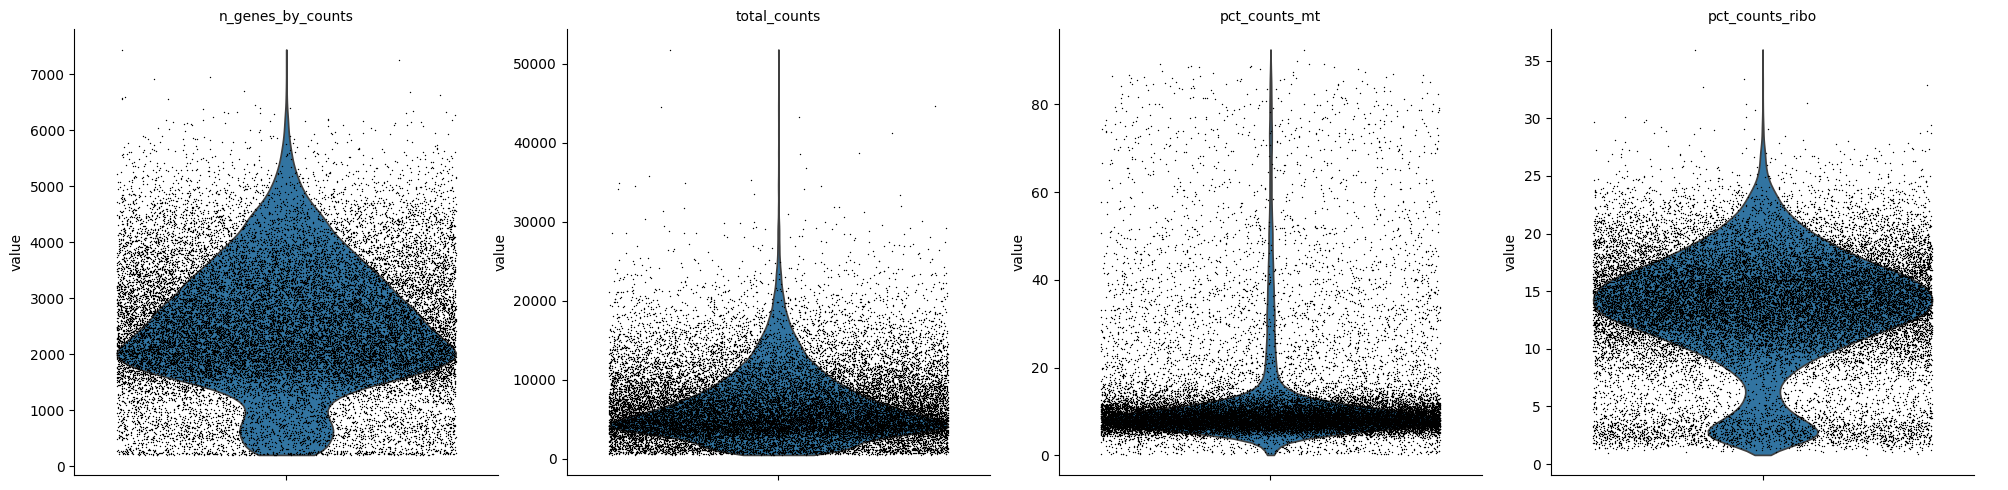

In [183]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [184]:
import numpy as np
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
upper_lim

4955.139999999999

In [185]:
adata = adata[adata.obs.n_genes_by_counts < 5000]
adata

View of AnnData object with n_obs × n_vars = 25523 × 23091
    obs: 'condition', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'Gene Clean Name', 'CRISPr', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [186]:
# upper_lim = np.quantile(adata.obs.pct_counts_mt.values, .98)
print(upper_lim)
adata = adata[adata.obs.pct_counts_mt < 20]
adata

4955.139999999999


View of AnnData object with n_obs × n_vars = 22813 × 23091
    obs: 'condition', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'Gene Clean Name', 'CRISPr', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [187]:
upper_lim = np.quantile(adata.obs.pct_counts_ribo.values, .98)
print(upper_lim)
adata = adata[(adata.obs.pct_counts_ribo > 7) & (adata.obs.pct_counts_ribo < 25)]
adata

22.95797981262207


View of AnnData object with n_obs × n_vars = 22088 × 23091
    obs: 'condition', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'Gene Clean Name', 'CRISPr', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

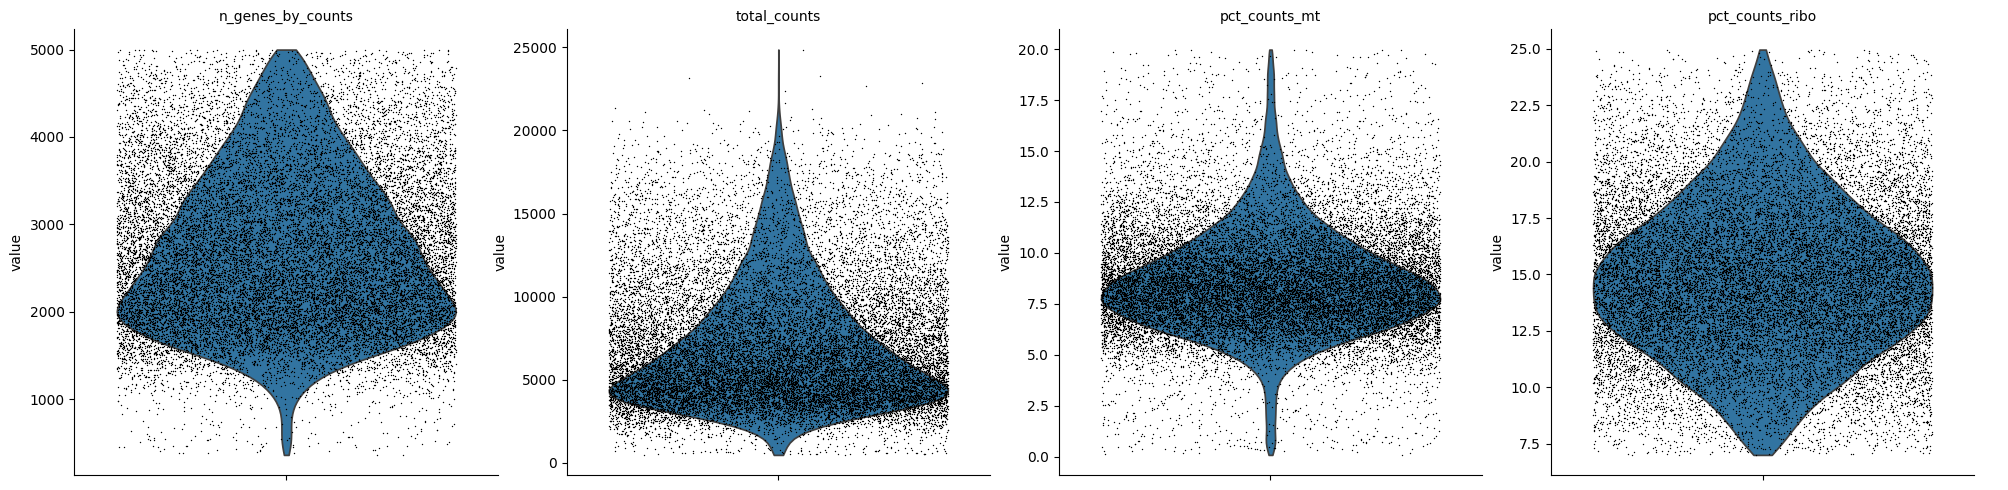

In [188]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

# Normalization

In [189]:
adata.X.sum(axis = 1)

matrix([[6823.],
        [7027.],
        [6902.],
        ...,
        [2817.],
        [4162.],
        [2758.]], dtype=float32)

In [190]:
sc.pp.normalize_total(adata, target_sum=1e4)

/home/julian/miniconda3/envs/cellrep/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [191]:
adata.X.sum(axis = 1)

matrix([[10000.001],
        [10000.   ],
        [10000.002],
        ...,
        [10000.001],
        [10000.   ],
        [10000.001]], dtype=float32)

In [192]:
sc.pp.log1p(adata) #change to log counts
adata.X.sum(axis = 1)

matrix([[3590.0273],
        [3274.9246],
        [3596.6807],
        ...,
        [2584.2783],
        [2880.8047],
        [2765.5405]], dtype=float32)

In [193]:
adata.raw = adata

In [194]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 59216259 stored elements and shape (22088, 23091)>

In [195]:
adata

AnnData object with n_obs × n_vars = 22088 × 23091
    obs: 'condition', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'Gene Clean Name', 'CRISPr', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'

# Clustering

In [196]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)

In [197]:
adata.var

,gene_ids,feature_types,Gene Clean Name,CRISPr,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000238009,Gene Expression,AL627309.1,perturbed,False,False,40,0.001492,99.850813,40.0,40,False,0.002483,0.764414,0.221661
AL627309.3,ENSG00000239945,Gene Expression,AL627309.3,perturbed,False,False,7,0.000261,99.973892,7.0,7,False,0.000366,0.352246,-1.052353
AL627309.5,ENSG00000241860,Gene Expression,AL627309.5,perturbed,False,False,307,0.011637,98.854990,312.0,307,False,0.019470,0.860564,0.518861
AL627309.4,ENSG00000241599,Gene Expression,AL627309.4,perturbed,False,False,7,0.000261,99.973892,7.0,7,False,0.000358,0.711085,0.056819
AL669831.2,ENSG00000229905,Gene Expression,AL669831.2,perturbed,False,False,5,0.000186,99.981352,5.0,5,False,0.000271,0.858453,0.512334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL354822.1,ENSG00000278384,Gene Expression,AL354822.1,perturbed,False,False,486,0.018648,98.187379,500.0,486,False,0.030332,0.714523,0.067447
AL592183.1,ENSG00000273748,Gene Expression,AL592183.1,perturbed,False,False,287,0.010816,98.929584,290.0,287,False,0.020131,0.817220,0.384883
AC240274.1,ENSG00000271254,Gene Expression,AC240274.1,perturbed,False,False,162,0.007124,99.395793,191.0,162,False,0.009821,0.689722,-0.009214
AC004556.3,ENSG00000276345,Gene Expression,AC004556.3,perturbed,False,False,3294,0.140310,87.714456,3762.0,3294,False,0.186061,0.567574,-0.386772


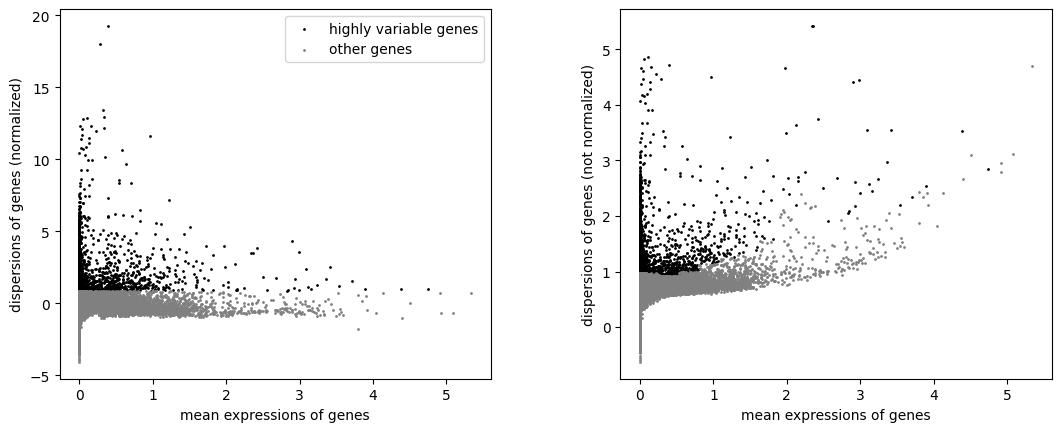

In [198]:
sc.pl.highly_variable_genes(adata)

In [199]:
adata = adata[:, adata.var.highly_variable]

In [200]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

/home/julian/miniconda3/envs/cellrep/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:668: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [201]:
sc.pp.scale(adata, max_value=10)

In [202]:
sc.tl.pca(adata, svd_solver='arpack')

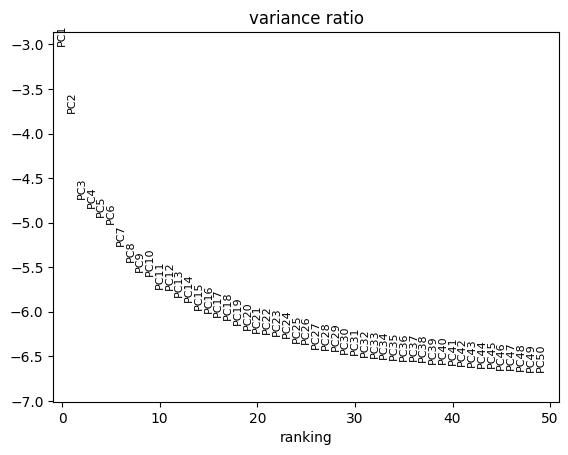

In [203]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [204]:
sc.pp.neighbors(adata, n_pcs = 10)

In [205]:
sc.tl.umap(adata)

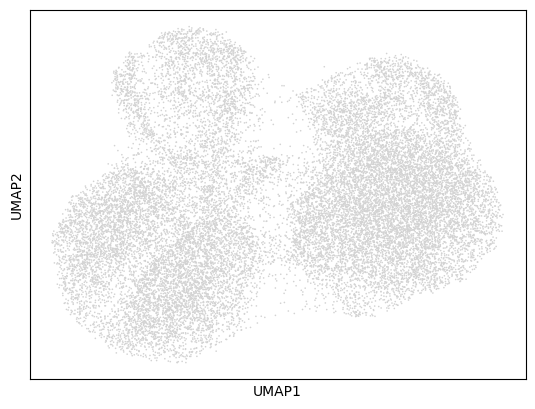

In [206]:
sc.pl.umap(adata)

In [222]:
sc.tl.leiden(adata, resolution = 0.2)

In [223]:
adata.obs

,condition,batch,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes,leiden
AAACCCACACAAATAG-5-0,Stim,0,2980,6823.0,807.0,11.827641,743.0,10.889638,2980,0
AAACCCAGTAAGACCG-5-0,Stim,0,2611,7027.0,373.0,5.308097,1097.0,15.611214,2611,0
AAACCCAGTCGTCGGT-5-0,Stim,0,3025,6902.0,1003.0,14.532020,648.0,9.388583,3025,0
AAACCCAGTGTTGACT-5-0,Stim,0,3613,10561.0,2070.0,19.600416,1024.0,9.696052,3613,0
AAACCCATCATAGCAC-5-0,Stim,0,3671,10525.0,813.0,7.724465,1577.0,14.983373,3671,0
...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTTACGGAG-1-1,Nostim,1,2149,5210.0,605.0,11.612284,918.0,17.619961,2149,2
TTTGTTGTCAATCCGA-1-1,Nostim,1,3518,10956.0,854.0,7.794815,1036.0,9.456006,3518,3
TTTGTTGTCCTACGGG-1-1,Nostim,1,1455,2817.0,202.0,7.170749,579.0,20.553782,1455,2
TTTGTTGTCGCTTGAA-1-1,Nostim,1,1897,4162.0,456.0,10.956271,728.0,17.491590,1897,1


In [226]:
(adata.obs[adata.obs['batch'] == '0']['leiden'] == '0').sum()

10870

In [210]:
adata.obs.leiden.value_counts()

leiden
0    10989
1     4963
2     3730
3     2406
Name: count, dtype: int64

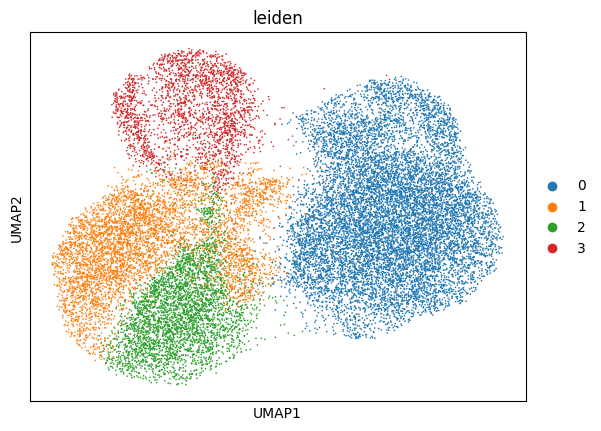

In [224]:
sc.pl.umap(adata, color=['leiden'])